In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
df_user_log=pd.read_csv('https://drive.google.com/uc?id=1DwEvKOYl0hQmd2muwDa13O17smPPgn0D')

In [4]:
df_user_info=pd.read_csv('https://drive.google.com/uc?id=1wM9LY4rAsMLGe6GUZNQd50R8WHiH9xaf')

In [5]:
df_user_log

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,234456,568,683,270,397.0,1110,0
1,234456,568,683,270,397.0,1110,0
2,234456,568,683,270,397.0,1110,0
3,234456,568,683,270,397.0,1110,0
4,234456,568,683,270,397.0,1111,2
...,...,...,...,...,...,...,...
7249,87449,504,1213,2264,3275.0,1015,0
7250,327950,517,1255,1653,1345.0,1111,0
7251,327950,517,1255,1653,1345.0,1111,0
7252,327950,517,1255,1653,1345.0,1111,2


In [6]:
df_user_log.describe()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
count,7254.000000,7254.000000,7254.000000,7254.000000,7248.000000,7254.000000,7254.00000
mean,212242.874414,550.680866,856.662807,2248.200441,3430.941777,918.570720,0.32327
std,123871.986646,45.550493,454.733960,1398.951493,2393.470654,196.713235,0.82503
min,192.000000,481.000000,22.000000,2.000000,99.000000,511.000000,0.00000
25%,101420.750000,517.000000,407.000000,1234.000000,1345.000000,729.000000,0.00000
50%,216374.000000,545.000000,748.000000,1923.000000,2462.000000,1006.000000,0.00000
75%,321987.000000,591.000000,1255.000000,3659.000000,5376.000000,1109.000000,0.00000
max,424094.000000,640.000000,1661.000000,4994.000000,8297.000000,1111.000000,3.00000


In [7]:
df_user_log.isnull().any()

user_id        False
item_id        False
cat_id         False
seller_id      False
brand_id        True
time_stamp     False
action_type    False
dtype: bool

In [8]:
import seaborn as sns

<Axes: xlabel='action_type', ylabel='count'>

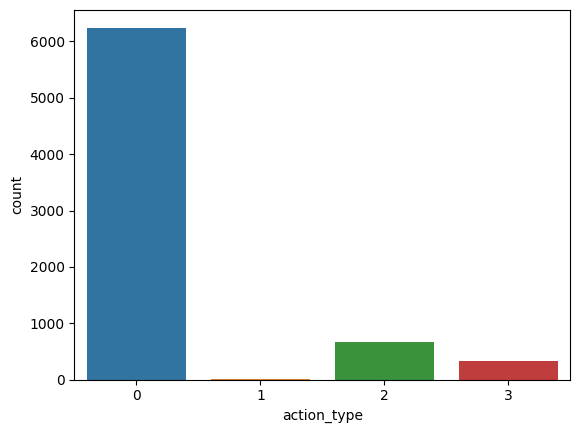

In [9]:
sns.countplot(x='action_type', data=df_user_log)

In [10]:
df_user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,234456,568,683,270,397.0,1110,0
1,234456,568,683,270,397.0,1110,0
2,234456,568,683,270,397.0,1110,0
3,234456,568,683,270,397.0,1110,0
4,234456,568,683,270,397.0,1111,2


In [11]:
df_user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [12]:
merged_df = pd.merge(df_user_log, df_user_info, on='user_id')

<Axes: xlabel='gender', ylabel='count'>

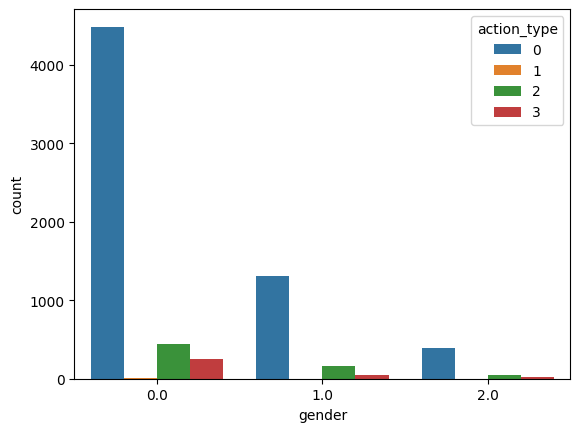

In [13]:
import seaborn as sns

sns.countplot(x='gender', hue='action_type', data=merged_df)

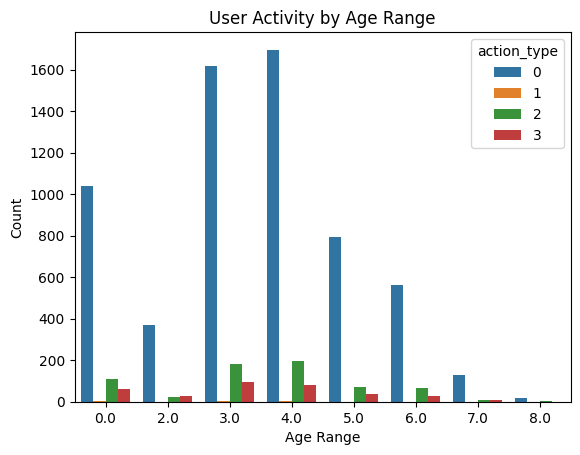

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a countplot of user activity by age range
sns.countplot(x='age_range', hue='action_type', data=merged_df)
plt.title('User Activity by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Count')

plt.show()


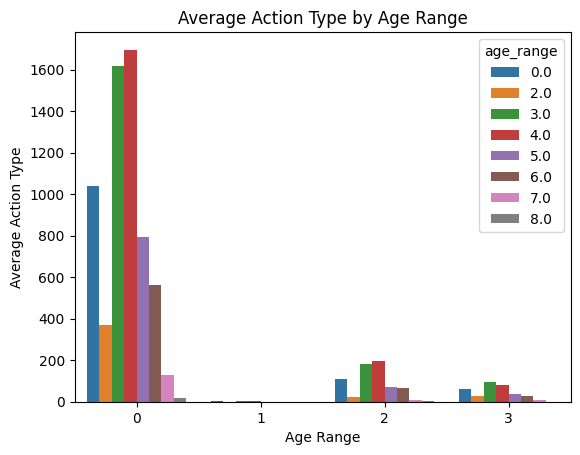

In [17]:
# create a barplot of average action type by age range
sns.countplot(x='action_type', hue='age_range', data=merged_df)
plt.title('Average Action Type by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Average Action Type')
plt.show()

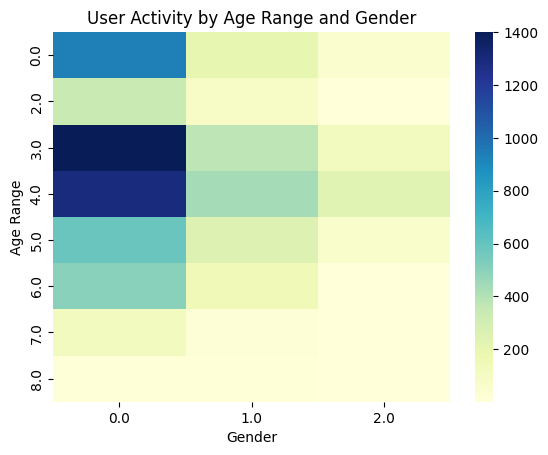

In [18]:
# create a heatmap of user activity by age range and gender
heatmap_df = merged_df.pivot_table(index='age_range', columns='gender', values='action_type', aggfunc='count')
sns.heatmap(heatmap_df, cmap='YlGnBu')
plt.title('User Activity by Age Range and Gender')
plt.xlabel('Gender')
plt.ylabel('Age Range')

plt.show()

<ipython-input-19-06bc133374a5>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged_df['Month'],hist=True)
<ipython-input-19-06bc133374a5>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged_df['Month'],hist=True)


<Axes: xlabel='Month', ylabel='Density'>

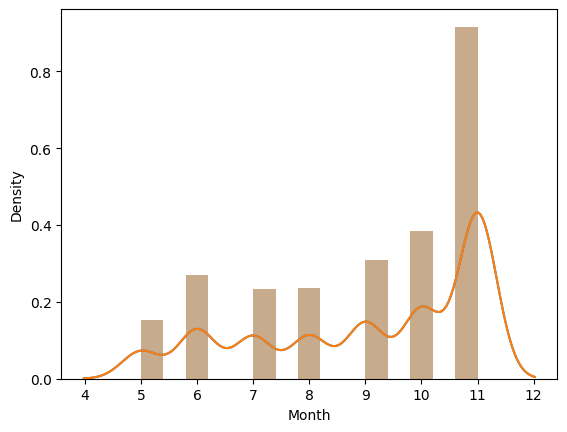

In [19]:
merged_df['time_stamp'].astype('str')
merged_df['time_str']= merged_df['time_stamp'].astype('str')
merged_df['Day']=merged_df['time_stamp']%100
merged_df['Month']=(merged_df['time_stamp']-merged_df['Day'])/100
merged_df['Month']= merged_df['Month'].astype('int')
sns.distplot(merged_df['Month'],hist=True)
merged_df['Month']= merged_df['Month'].astype('int')
sns.distplot(merged_df['Month'],hist=True)
